# Tune single wake

Use the 8 m/s two turbine aligned case to find better tunings for new gauss model

In [1]:
import matplotlib.pyplot as plt
import floris.tools as wfct
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import pickle
from scipy.optimize import minimize

## Load FLORIS models and SOWFA DATA

In [2]:
df = pickle.load( open( "sowfa_04.p", "rb" ) )
fi_dict = pickle.load( open( "floris_models.p", "rb" ) )

## Limit DF to 2 turbine aligned cases

In [3]:
# Limit to aligned only
print(df.shape)
df = df[df.yaw.apply(lambda x: np.max(np.abs(x)))==0.0]
# Limit to 2-turbine
df = df[df.num_turbines==2]
df.shape

(679, 21)


(95, 21)

In [4]:
# Limit to 8 m/s
df = df[df.sowfa_U0==8.]
df.shape

(23, 21)

In [5]:
df.head()

,Precursor,case_name,floris_TI,floris_U0,layout_x,layout_y,num_turbines,path,sim_length,sowfa_TI,...,yaw,power,ti,d_spacing,wake_table,freestream_gauss,freestream_gauss_tune,freestream_gch_paper,freestream_legacy,freestream_ti
casename,,,,,,,,,,,,,,,,,,,,,
c_1,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R-1_y00,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 937.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,...,"[0.0, 0.0]","[1937.5, 1072.3]","[0.09297835821594881, 0.17988567028143654]",5.0,"[0, 1]",8.372666,8.394857,8.372666,8.372666,0.092978
c_4,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R00_y00,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 1000.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,...,"[0.0, 0.0]","[1938.0, 752.7]","[0.09285372321562335, 0.10368956548356832]",5.0,"[0, 1]",8.373387,8.395580,8.373387,8.373387,0.092854
c_7,neutral_5kmx2kmx1km\n,c_08_highTI_D05_R01_y00,0.09,8.38,"(1000.0, 1630.0)","(1000.0, 1063.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,...,"[0.0, 0.0]","[1936.5, 1217.5]","[0.09287234272241693, 0.18262414962645512]",5.0,"[0, 1]",8.371224,8.393411,8.371224,8.371224,0.092872
c_9,neutral_5kmx2kmx1km\n,B_031_nhigh_yaw_base_Lno3,0.09,8.38,"(1000.0, 1756.0)","(850.0, 850.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,...,"[0.0, 0.0]","[1544.4, 777.9]","[0.11618824493314393, 0.15359956312474723]",6.0,"[0, 1]",7.762017,7.782589,7.762017,7.762017,0.116188
c_13,neutral_5kmx2kmx1km\n,C_031_nhigh_yaw_base_Lno3,0.09,8.38,"(1000.0, 1756.0)","(1000.0, 1000.0)",2,sowfa_library (Paul.fleming@nrel.gov)/full_run...,2000.0,0.1,...,"[0.0, 0.0]","[1940.5, 849.7]","[0.09288069329397876, 0.11507991641962763]",6.0,"[0, 1]",8.376989,8.399191,8.376989,8.376989,0.092881


## How do the models start out?

In [6]:
def get_t1_powers(fi, floris_label, df):
    print(floris_label)
    t1_powers = []
    for i, row in df.iterrows():

        # Determine free-stream wind speed column
        freestream_name = 'freestream_' + floris_label

        
        # Match the layout
        if (floris_label == 'gch_paper') or (floris_label == 'legacy') :
                fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                               wind_speed=[row[freestream_name]],
                              turbulence_intensity=[row.floris_TI])
        else:
            fi.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                                       wind_speed=[row[freestream_name]],
                                      turbulence_intensity=[row.freestream_ti])


        fi.calculate_wake()
        
        t1_powers.append(fi.get_turbine_power()[1]/1000.)
    return np.array(t1_powers)

In [7]:
for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]
    
    t1_powers = get_t1_powers(fi, floris_label, df)
    
    power_key = 'power_' + floris_label
    df[power_key] = t1_powers

gauss
gauss_tune
gch_paper
legacy


In [8]:
# Pull out the t1 sowfa power
df['sowfa_1'] = df.power.apply(lambda x: x[1])

Text(0, 0.5, 'FLORIS Power')

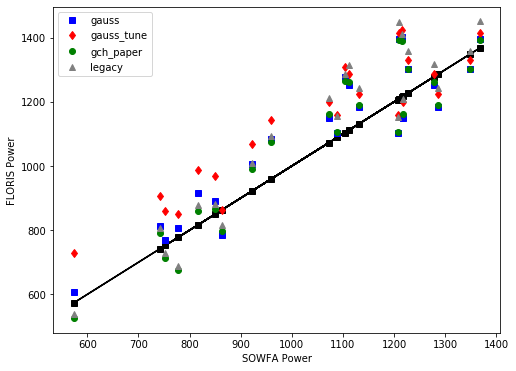

In [9]:
# How does this look in absolute terms?
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df.sowfa_1,df.sowfa_1,'ks-')
for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]
    power_signal = 'power_' + floris_label
    ax.plot(df.sowfa_1,df[power_signal],color=floris_color,marker=floris_marker,label=floris_label,ls='None')

ax.legend()
ax.set_xlabel('SOWFA Power')
ax.set_ylabel('FLORIS Power')

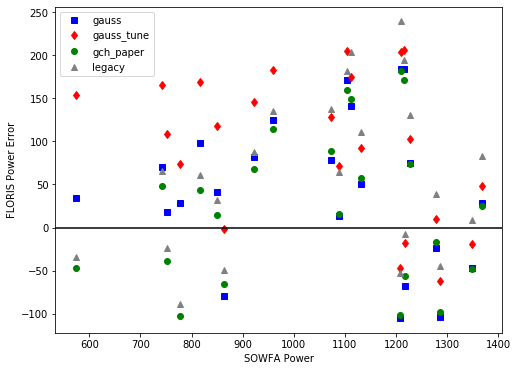

In [10]:
# How does error look
fig, ax = plt.subplots(figsize=(8,6))

for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]
    power_signal = 'power_' + floris_label
    error_signal = 'error_' + floris_label
    df[error_signal] = df[power_signal] - df.sowfa_1
    ax.plot(df.sowfa_1,df[error_signal],color=floris_color,marker=floris_marker,label=floris_label,ls='None')

ax.legend()
ax.set_xlabel('SOWFA Power')
ax.set_ylabel('FLORIS Power Error')
ax.axhline(0,color='k')

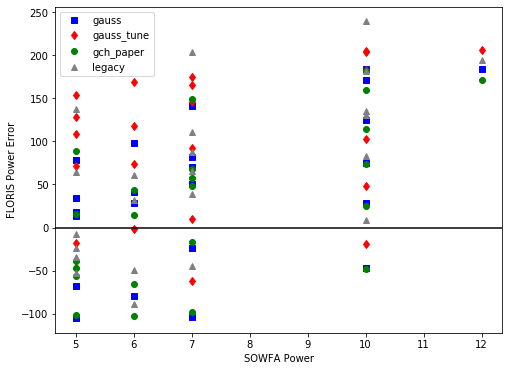

In [11]:
# Plot again by d-spacing
fig, ax = plt.subplots(figsize=(8,6))

for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]
    power_signal = 'power_' + floris_label
    error_signal = 'error_' + floris_label
    df[error_signal] = df[power_signal] - df.sowfa_1
    ax.plot(df.d_spacing,df[error_signal],color=floris_color,marker=floris_marker,label=floris_label,ls='None')

ax.legend()
ax.set_xlabel('SOWFA Power')
ax.set_ylabel('FLORIS Power Error')
ax.axhline(0,color='k')

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


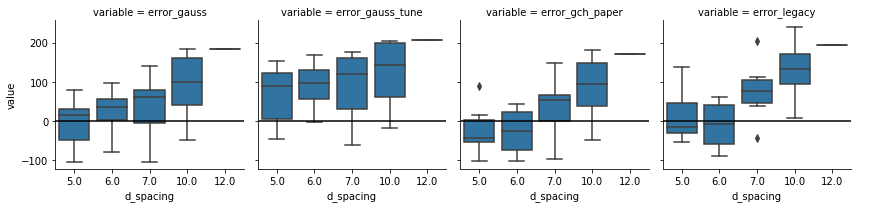

In [12]:
error_columns = [c for c in df.columns if 'error' in c]
df_sub = df[error_columns + ['d_spacing']]
df_sub = pd.melt(df_sub,id_vars='d_spacing')
g = sns.FacetGrid(df_sub,col='variable',aspect=1)
g.map(sns.boxplot,'d_spacing','value')
for ax in g.axes.flatten():
    ax.axhline(0,color='k')
g.add_legend()

Shows that previous version of gauss had reasonable calibration for deeper wakes but under-forecasted medium, probably not wide enough

## How do the overall errors compare

In [13]:
def compute_rms(df,floris_column):
    error_column = df[floris_column] 
    return np.sqrt(np.sum((error_column**2))/len(error_column))

In [14]:
for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]

    error_signal = 'error_' + floris_label

    print(floris_label,':',compute_rms(df,error_signal))


gauss : 95.36319318641384591
gauss_tune : 127.25599708134250419
gch_paper : 91.9056028730994
legacy : 110.89770917628563


New version without tuning is, as we know, worse

## Try to find an improved tuning for gauss ka/kb

In [15]:
# Define a tuning error function
(fi_tune, floris_color, floris_marker, floris_label) = fi_dict['gt']

model_params = fi_tune.get_model_parameters()


def tuning_error_function(x): #where x = [ka, kb]
    
    # Change the parameters
    model_params['Wake Velocity Parameters']['ka'] = x[0] * 0.38 # how much to scale inital by
    model_params['Wake Velocity Parameters']['kb'] = .002 # x[1] * 0.004 * 10
    fi_tune.set_model_parameters(model_params,verbose=False)
    
    # Get the powers for each case
    t1_powers = np.zeros_like(df.sowfa_1.values)
    num_case = len(t1_powers)
    for idx, (i, row) in enumerate(df.iterrows()):

        # Determine free-stream wind speed column
        freestream_name = 'freestream_gauss_tune'
        
        # Match the layout

        fi_tune.reinitialize_flow_field(layout_array=[row.layout_x,row.layout_y],
                                   wind_speed=[row[freestream_name]],
                                  turbulence_intensity=[row.freestream_ti])


        fi_tune.calculate_wake()
        
        t1_powers[idx] = fi_tune.get_turbine_power()[1]/1000.
        
    # Return the RMS error
    error_values = df.sowfa_1.values - t1_powers
    rms = np.sqrt(np.sum((error_values**2))/num_case)
    print(x,x[0] * 0.38,x[1] * 0.004,rms)
    return rms
        
        
    

In [16]:
# Find well fit values
result = minimize(tuning_error_function, x0=[1, 1],bounds=[(0.001,100.),(0.0001,100.)])

[1. 1.] 0.38 0.004 117.29003094175701
[1.00000001 1.        ] 0.3800000038 0.004 117.29003256905182
[1.         1.00000001] 0.38 0.00400000004 117.29003094175701
[0.001 1.   ] 0.00038 0.004 200.52558391181415
[0.00100001 1.        ] 0.0003800038 0.004 200.52557993779098
[1.00000000e-03 1.00000001e+00] 0.00038 0.00400000004 200.52558391181415
[0.64700259 1.        ] 0.24586098330028286 0.004 70.58637618014723
[0.6470026 1.       ] 0.2458609871002829 0.004 70.5863767629329
[0.64700259 1.00000001] 0.24586098330028286 0.00400000004 70.58637618014723
[0.45004707 1.        ] 0.17101788739153023 0.004 77.27287553092074
[0.45004708 1.        ] 0.17101789119153024 0.004 77.27287422328136
[0.45004707 1.00000001] 0.17101788739153023 0.00400000004 77.27287553092074
[0.58395906 1.        ] 0.22190444230228432 0.004 68.60553069482802
[0.58395907 1.        ] 0.22190444610228435 0.004 68.60553072070336
[0.58395906 1.00000001] 0.22190444230228432 0.00400000004 68.60553069482802
[0.58102991 1.        ] 

In [17]:
result.x

array([0.58129175, 1.        ])

In [18]:
result.x

array([0.58129175, 1.        ])

In [1]:
 0.38 * .581

0.22077999999999998

In [19]:
# Based on the above analysis, let's just assume that an approximate 50% drop
# Add this tuned value to dictionary and compare
model_params['Wake Velocity Parameters']['ka'] = 0.38 * .581 # result.x[0] # 0.38
model_params['Wake Velocity Parameters']['kb'] = 0.002 # result.x[1] # 0.004
fi_tune.set_model_parameters(model_params)

fi_dict['gt'] = (fi_tune,'r','d','gauss_tune')

Wake velocity parameter alpha set to 0.58
Wake velocity parameter beta set to 0.077
Wake velocity parameter calculate_VW_velocities set to True
Wake velocity parameter eps_gain set to 0.3
Wake velocity parameter ka set to 0.22077999999999998
Wake velocity parameter kb set to 0.002
Wake velocity parameter use_yaw_added_recovery set to True
Wake velocity parameter yaw_recovery_alpha set to 0.03
Wake deflection parameter ad set to 0.0
Wake deflection parameter alpha set to 0.58
Wake deflection parameter bd set to 0.0
Wake deflection parameter beta set to 0.077
Wake deflection parameter eps_gain set to 0.3
Wake deflection parameter ka set to 0.38
Wake deflection parameter kb set to 0.004
Wake deflection parameter use_secondary_steering set to True
Wake turbulence parameter ti_ai set to 0.8
Wake turbulence parameter ti_constant set to 0.73
Wake turbulence parameter ti_downstream set to -0.275
Wake turbulence parameter ti_initial set to 0.1


In [20]:
# Recalculate
for floris_key in fi_dict:
    (fi, floris_color, floris_marker,floris_label) = fi_dict[floris_key]
    
    t1_powers = get_t1_powers(fi, floris_label, df)
    
    power_key = 'power_' + floris_label
    df[power_key] = t1_powers

gauss
gauss_tune
gch_paper
legacy


Text(0, 0.5, 'FLORIS Power')

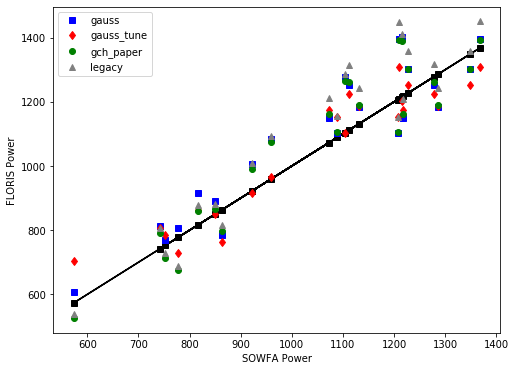

In [21]:
# How does this look in absolute terms?
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df.sowfa_1,df.sowfa_1,'ks-')
for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]
    power_signal = 'power_' + floris_label
    ax.plot(df.sowfa_1,df[power_signal],color=floris_color,marker=floris_marker,label=floris_label,ls='None')

ax.legend()
ax.set_xlabel('SOWFA Power')
ax.set_ylabel('FLORIS Power')

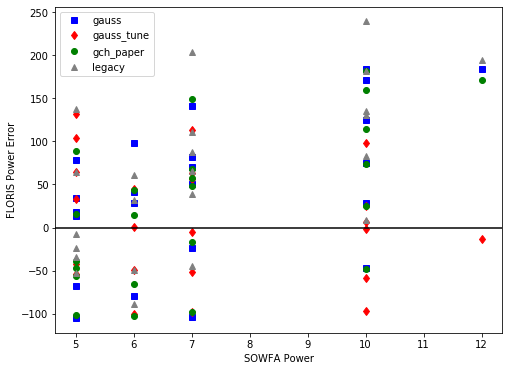

In [22]:
# Plot again by d-spacing
fig, ax = plt.subplots(figsize=(8,6))

for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]
    power_signal = 'power_' + floris_label
    error_signal = 'error_' + floris_label
    df[error_signal] = df[power_signal] - df.sowfa_1
    ax.plot(df.d_spacing,df[error_signal],color=floris_color,marker=floris_marker,label=floris_label,ls='None')

ax.legend()
ax.set_xlabel('SOWFA Power')
ax.set_ylabel('FLORIS Power Error')
ax.axhline(0,color='k')

/Users/pfleming/opt/anaconda3/envs/floris/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


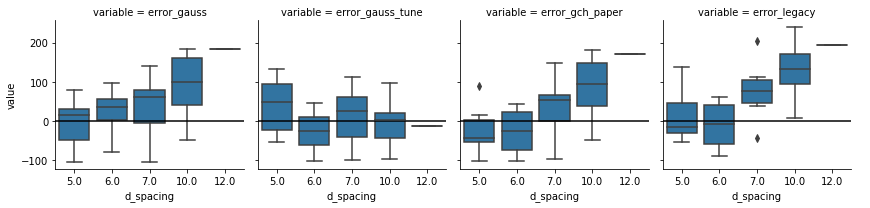

In [23]:
error_columns = [c for c in df.columns if 'error' in c]
df_sub = df[error_columns + ['d_spacing']]
df_sub = pd.melt(df_sub,id_vars='d_spacing')
g = sns.FacetGrid(df_sub,col='variable',aspect=1)
g.map(sns.boxplot,'d_spacing','value')
for ax in g.axes.flatten():
    ax.axhline(0,color='k')
g.add_legend()

In [24]:
for floris_key in fi_dict:
    (fi, floris_color, floris_marker, floris_label) = fi_dict[floris_key]

    error_signal = 'error_' + floris_label

    print(floris_label,':',compute_rms(df,error_signal))


gauss : 95.36319318641384591
gauss_tune : 68.60211823939645362
gch_paper : 91.9056028730994
legacy : 110.89770917628563


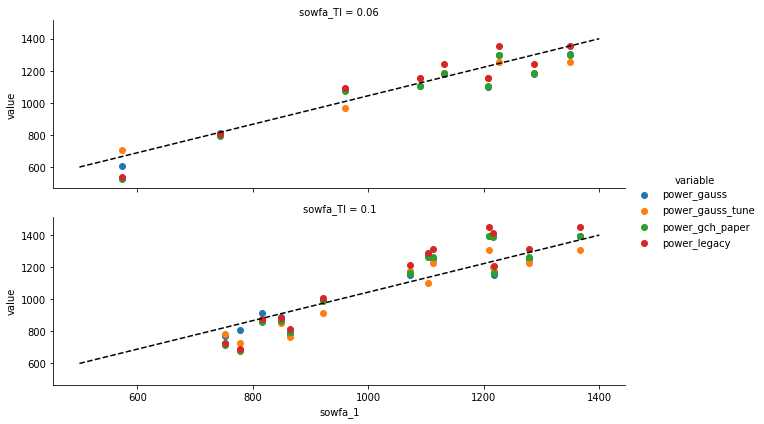

In [25]:
# Lets replot this by sowfa ti
power_columns = [c for c in df.columns if 'power_' in c]
df_sub = df[['sowfa_TI','sowfa_1'] + power_columns]
df_sub = pd.melt(df_sub,id_vars=['sowfa_TI','sowfa_1'])
g = sns.FacetGrid(df_sub,row='sowfa_TI',hue='variable',aspect=3)
g.map(plt.scatter,'sowfa_1','value')
g.add_legend()
for ax in g.axes.flatten():
    ax.plot([500,1400],[600,1400],'k--')

In [26]:
# Save this new floris dictionary
fi_dict


{'g': (<floris.tools.floris_interface.FlorisInterface at 0x1082c0890>,
  'b',
  's',
  'gauss'),
 'gt': (<floris.tools.floris_interface.FlorisInterface at 0x119e24e10>,
  'r',
  'd',
  'gauss_tune'),
 'gch': (<floris.tools.floris_interface.FlorisInterface at 0x119e295d0>,
  'g',
  'o',
  'gch_paper'),
 'leg': (<floris.tools.floris_interface.FlorisInterface at 0x119e2d810>,
  'gray',
  '^',
  'legacy')}

In [27]:
pickle.dump( fi_dict, open( "floris_models_2.p", "wb" ) )